### This is a new version of MLEAP scripts, started in late Aug 2022.
It will combine IProject_MLEAP_ANN and IP_MLEAP script, while improving them.

#### Outline

1. Load libraries and data.
2. pEDA. Look at feature distribution, fix them if they do not look right.
3. Train-test split. Most likely couple years into test set. 2015-2018?. Impute missing values.
4. Transform numerical features, add ohe for inds.
5. Fit classic models: ols as a baseline, then xgb.
6. Fir DL.


Notes:
ideally, I want to use time-based cross-validation.
since I have panel data, it is not a trivial task.
need to find some solution online.
e.g., https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8.

for now, will try to do siple for loop.


In [261]:
# 0. Import libraries #

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, time, math, re, warnings, random, gc, dill, optuna, pickle
import statsmodels.api as sm
from random import sample

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNetCV
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

plt.style.use('seaborn-white')
warnings.simplefilter(action='ignore')
pd.set_option('display.max_columns', 110)
gc.enable()

In [262]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [263]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [264]:
# 1. Import data #

# window: 3y seems good?

min_prd = 440
windows_width = 20*12

time0 = time.time()
#df = pd.read_csv('../input/cpcrsp-46/IMLEAP_v4.csv')
with open('../input/kaggle-46pkl/IMLEAP_v4.pkl', 'rb') as pickled_one:
    df = pickle.load(pickled_one)
df = df[df.prd.isin(range(min_prd-1, min_prd+windows_width+2))]
display(df.shape, df.head(), df.year.describe(), df.count())

(544359, 46)

,PERMNO,prd,mom482,mom242,year,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,BAspr,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l1BAspr,l3amhd,l3MAX,l3BAspr,l6amhd,l6MAX,l6BAspr,l12amhd,l12MAX,l12BAspr,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m
303,10010,439,-36.444004,-29.452329,1994,6.7729,12.0,-1.896125,0.081622,0.510535,-0.101827,-12.8800,19.791286,2.750014,1.775980,1.419561,1.319895,2.3630,1.982098,3.306168,3.443560,4.705882,3.979242,-1.623669,0.013844,0.291257,0.8003,3.910066,2.800786,6.6497,2.040816,2.748052,4.4304,6.976744,2.715808,13.0295,1.526718,2.538076,6.6497,1.960784,-36.488730,5.092653,4.290265,0.700595,3.609285,3.578975
304,10010,440,-27.004838,-39.594954,1994,-11.5511,12.0,-1.896125,0.081622,0.510535,-0.101827,6.7729,19.978580,2.727015,3.174275,2.586294,1.154507,7.1249,3.204259,3.347538,3.420432,4.651163,4.048235,-1.623669,0.013844,0.291257,0.8003,3.773491,2.750014,2.3630,4.705882,2.780270,7.3011,4.347826,2.761309,7.6773,1.562500,2.590794,2.3630,5.000000,-36.684897,3.559160,2.977536,0.799717,3.789539,3.641639
305,10010,441,-52.312316,-46.967739,1995,4.5800,12.0,-1.896125,0.081622,0.510535,-0.101827,-11.5511,6.309380,2.778245,3.727031,3.549946,1.096501,7.4790,3.931532,2.979029,3.420743,4.651163,3.930452,-1.623669,0.013844,0.291257,0.8003,3.961848,2.727015,7.1249,4.651163,2.800786,6.6497,2.040816,2.701712,3.2647,4.545455,2.614138,7.1249,2.272727,-52.929807,3.158877,2.559848,0.934201,3.785383,3.654135
306,10010,442,-56.784641,-41.811089,1995,-14.6857,12.0,-1.896125,0.081622,0.510535,-0.101827,4.5800,-15.182623,2.990514,3.595954,2.844724,1.082249,7.4800,3.726123,3.111476,3.481510,4.761905,3.996084,-1.623669,0.013844,0.291257,0.8003,4.067744,2.778245,7.4790,4.651163,2.750014,2.3630,4.705882,2.748052,4.4304,6.976744,2.672362,7.4790,1.851852,-43.742392,2.653927,2.305796,1.013058,3.790353,3.529957
307,10010,443,-69.345721,-41.681696,1995,-14.3489,12.0,-1.896125,0.081622,0.510535,-0.101827,-14.6857,-20.652999,3.097367,3.617254,3.351837,0.946213,4.8570,3.484299,3.264820,3.459034,5.263158,3.841933,-1.623669,0.013844,0.291257,0.8003,4.181073,2.990514,7.4800,4.761905,2.727015,7.1249,4.651163,2.780270,7.3011,4.347826,2.689200,7.4800,3.448276,-33.892145,3.569129,3.223442,0.916606,3.934643,3.467386


count    544359.000000
mean        548.882728
std          69.207974
min         439.000000
25%         488.000000
50%         543.000000
75%         607.000000
max         681.000000
Name: prd, dtype: float64

PERMNO          544359
prd             544359
mom482          470520
mom242          535078
year            544359
RET             544359
ind             544359
bm              544359
op              544359
gp              544359
inv             543703
mom11           544359
mom122          544359
amhd            501997
ivol_capm       544343
ivol_ff5        544343
beta_bw         544359
MAX             544359
vol1m           544335
vol6m           543733
vol12m          542713
BAspr           526174
size            544359
lbm             544359
lop             544359
lgp             544359
linv            544359
llme            544359
l1amhd          501867
l1MAX           544335
l1BAspr         526193
l3amhd          501577
l3MAX           544189
l3BAspr         526074
l6amhd          501097
l6MAX           544064
l6BAspr         525918
l12amhd         500012
l12MAX          544335
l12BAspr        525769
l12mom122       543019
l12ivol_capm    543844
l12ivol_ff5     543844
l12beta_bw 

(544359, 46)
(539463, 46)


<AxesSubplot:>

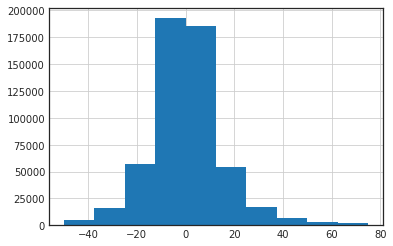

In [265]:
# 2. pEDA #

print(df.shape)
df = df[(df.RET>-50)&(df.RET<75)]
print(df.shape)
df.RET.hist()

In [266]:
meanret = df.groupby('prd').RET.mean().to_frame().reset_index().rename(columns={'RET':'mRET'})
df = pd.merge(df, meanret, on='prd', how='left')
display(df, df[['RET', 'mRET']].describe())
df.RET = df.RET-df.mRET
df.drop(columns='mRET', inplace=True)
display(df, df[['RET']].describe())

,PERMNO,prd,mom482,mom242,year,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,BAspr,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l1BAspr,l3amhd,l3MAX,l3BAspr,l6amhd,l6MAX,l6BAspr,l12amhd,l12MAX,l12BAspr,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m,mRET
0,10010,439,-36.444004,-29.452329,1994,6.7729,12.0,-1.896125,0.081622,0.510535,-0.101827,-12.8800,19.791286,2.750014,1.775980,1.419561,1.319895,2.3630,1.982098,3.306168,3.443560,4.705882,3.979242,-1.623669,0.013844,0.291257,0.800300,3.910066,2.800786,6.6497,2.040816,2.748052,4.4304,6.976744,2.715808,13.0295,1.526718,2.538076,6.6497,1.960784,-36.488730,5.092653,4.290265,0.700595,3.609285,3.578975,-4.001305
1,10010,440,-27.004838,-39.594954,1994,-11.5511,12.0,-1.896125,0.081622,0.510535,-0.101827,6.7729,19.978580,2.727015,3.174275,2.586294,1.154507,7.1249,3.204259,3.347538,3.420432,4.651163,4.048235,-1.623669,0.013844,0.291257,0.800300,3.773491,2.750014,2.3630,4.705882,2.780270,7.3011,4.347826,2.761309,7.6773,1.562500,2.590794,2.3630,5.000000,-36.684897,3.559160,2.977536,0.799717,3.789539,3.641639,-1.444989
2,10010,441,-52.312316,-46.967739,1995,4.5800,12.0,-1.896125,0.081622,0.510535,-0.101827,-11.5511,6.309380,2.778245,3.727031,3.549946,1.096501,7.4790,3.931532,2.979029,3.420743,4.651163,3.930452,-1.623669,0.013844,0.291257,0.800300,3.961848,2.727015,7.1249,4.651163,2.800786,6.6497,2.040816,2.701712,3.2647,4.545455,2.614138,7.1249,2.272727,-52.929807,3.158877,2.559848,0.934201,3.785383,3.654135,1.879630
3,10010,442,-56.784641,-41.811089,1995,-14.6857,12.0,-1.896125,0.081622,0.510535,-0.101827,4.5800,-15.182623,2.990514,3.595954,2.844724,1.082249,7.4800,3.726123,3.111476,3.481510,4.761905,3.996084,-1.623669,0.013844,0.291257,0.800300,4.067744,2.778245,7.4790,4.651163,2.750014,2.3630,4.705882,2.748052,4.4304,6.976744,2.672362,7.4790,1.851852,-43.742392,2.653927,2.305796,1.013058,3.790353,3.529957,2.604521
4,10010,443,-69.345721,-41.681696,1995,-14.3489,12.0,-1.896125,0.081622,0.510535,-0.101827,-14.6857,-20.652999,3.097367,3.617254,3.351837,0.946213,4.8570,3.484299,3.264820,3.459034,5.263158,3.841933,-1.623669,0.013844,0.291257,0.800300,4.181073,2.990514,7.4800,4.761905,2.727015,7.1249,4.651163,2.780270,7.3011,4.347826,2.689200,7.4800,3.448276,-33.892145,3.569129,3.223442,0.916606,3.934643,3.467386,1.337433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539458,93423,677,NaN,36.547077,2014,-5.7292,7.0,-1.909081,0.130961,0.232296,-0.146767,-3.3229,19.973722,-3.297632,0.765013,0.647098,0.988961,1.8725,1.008846,1.133002,1.274300,0.029163,8.153553,-1.226522,0.100139,0.189565,0.154149,8.051708,-3.247683,2.7474,0.029163,-3.241532,2.3892,0.029163,-3.222051,4.6275,0.029163,-3.369867,2.7474,0.030075,38.595673,1.016872,0.987725,0.733487,1.465130,1.541785,-5.409159
539459,93423,678,NaN,32.788007,2014,17.1852,7.0,-1.909081,0.130961,0.232296,-0.146767,-5.7292,13.309720,-3.309886,0.968891,0.949449,1.005908,2.2163,1.192428,1.140671,1.271179,0.029394,8.094554,-1.226522,0.100139,0.189565,0.154149,8.075062,-3.297632,1.8725,0.029163,-3.238086,2.4722,0.047048,-3.226472,1.4066,0.029163,-3.386130,1.8725,0.029481,18.408836,1.229472,0.744911,0.739018,1.523474,1.536778,2.322733
539460,93423,679,NaN,49.498520,2014,2.1588,7.0,-1.909081,0.130961,0.232296,-0.146767,17.1852,-4.031370,-3.346410,3.154258,2.919253,0.895993,12.7536,3.318292,1.724541,1.501585,0.029163,8.235542,-1.226522,0.100139,0.189565,0.154149,8.182535,-3.309886,2.2163,0.029394,-3.247683,2.7474,0.029163,-3.219131,2.1480,0.029163,-3.355495,2.2163,0.029163,24.806256,1.452399,1.289774,0.777137,1.444792,1.440309,-0.527243
539461,93423,680,NaN,47.334869,2014,6.1501,7.0,-1.909081,0.130961,0.232296,-0.146767,2.1588,12.252130,-3.347909,1.091280,0.985025,0.907071,2.2251,1.051347,1.729861,1.502649,0.049298,8.244189,-1.226522,0.100139,0.189565,0.154149,8.1718

,RET,mRET
count,539463.000000,539463.000000
mean,0.632014,0.632014
std,14.872897,5.235497
min,-49.990400,-20.709770
25%,-7.238200,-2.422211
50%,-0.022700,1.120586
75%,7.454250,4.102920
max,74.998600,18.422416


,PERMNO,prd,mom482,mom242,year,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,BAspr,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l1BAspr,l3amhd,l3MAX,l3BAspr,l6amhd,l6MAX,l6BAspr,l12amhd,l12MAX,l12BAspr,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m
0,10010,439,-36.444004,-29.452329,1994,10.774205,12.0,-1.896125,0.081622,0.510535,-0.101827,-12.8800,19.791286,2.750014,1.775980,1.419561,1.319895,2.3630,1.982098,3.306168,3.443560,4.705882,3.979242,-1.623669,0.013844,0.291257,0.800300,3.910066,2.800786,6.6497,2.040816,2.748052,4.4304,6.976744,2.715808,13.0295,1.526718,2.538076,6.6497,1.960784,-36.488730,5.092653,4.290265,0.700595,3.609285,3.578975
1,10010,440,-27.004838,-39.594954,1994,-10.106111,12.0,-1.896125,0.081622,0.510535,-0.101827,6.7729,19.978580,2.727015,3.174275,2.586294,1.154507,7.1249,3.204259,3.347538,3.420432,4.651163,4.048235,-1.623669,0.013844,0.291257,0.800300,3.773491,2.750014,2.3630,4.705882,2.780270,7.3011,4.347826,2.761309,7.6773,1.562500,2.590794,2.3630,5.000000,-36.684897,3.559160,2.977536,0.799717,3.789539,3.641639
2,10010,441,-52.312316,-46.967739,1995,2.700370,12.0,-1.896125,0.081622,0.510535,-0.101827,-11.5511,6.309380,2.778245,3.727031,3.549946,1.096501,7.4790,3.931532,2.979029,3.420743,4.651163,3.930452,-1.623669,0.013844,0.291257,0.800300,3.961848,2.727015,7.1249,4.651163,2.800786,6.6497,2.040816,2.701712,3.2647,4.545455,2.614138,7.1249,2.272727,-52.929807,3.158877,2.559848,0.934201,3.785383,3.654135
3,10010,442,-56.784641,-41.811089,1995,-17.290221,12.0,-1.896125,0.081622,0.510535,-0.101827,4.5800,-15.182623,2.990514,3.595954,2.844724,1.082249,7.4800,3.726123,3.111476,3.481510,4.761905,3.996084,-1.623669,0.013844,0.291257,0.800300,4.067744,2.778245,7.4790,4.651163,2.750014,2.3630,4.705882,2.748052,4.4304,6.976744,2.672362,7.4790,1.851852,-43.742392,2.653927,2.305796,1.013058,3.790353,3.529957
4,10010,443,-69.345721,-41.681696,1995,-15.686333,12.0,-1.896125,0.081622,0.510535,-0.101827,-14.6857,-20.652999,3.097367,3.617254,3.351837,0.946213,4.8570,3.484299,3.264820,3.459034,5.263158,3.841933,-1.623669,0.013844,0.291257,0.800300,4.181073,2.990514,7.4800,4.761905,2.727015,7.1249,4.651163,2.780270,7.3011,4.347826,2.689200,7.4800,3.448276,-33.892145,3.569129,3.223442,0.916606,3.934643,3.467386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539458,93423,677,NaN,36.547077,2014,-0.320041,7.0,-1.909081,0.130961,0.232296,-0.146767,-3.3229,19.973722,-3.297632,0.765013,0.647098,0.988961,1.8725,1.008846,1.133002,1.274300,0.029163,8.153553,-1.226522,0.100139,0.189565,0.154149,8.051708,-3.247683,2.7474,0.029163,-3.241532,2.3892,0.029163,-3.222051,4.6275,0.029163,-3.369867,2.7474,0.030075,38.595673,1.016872,0.987725,0.733487,1.465130,1.541785
539459,93423,678,NaN,32.788007,2014,14.862467,7.0,-1.909081,0.130961,0.232296,-0.146767,-5.7292,13.309720,-3.309886,0.968891,0.949449,1.005908,2.2163,1.192428,1.140671,1.271179,0.029394,8.094554,-1.226522,0.100139,0.189565,0.154149,8.075062,-3.297632,1.8725,0.029163,-3.238086,2.4722,0.047048,-3.226472,1.4066,0.029163,-3.386130,1.8725,0.029481,18.408836,1.229472,0.744911,0.739018,1.523474,1.536778
539460,93423,679,NaN,49.498520,2014,2.686043,7.0,-1.909081,0.130961,0.232296,-0.146767,17.1852,-4.031370,-3.346410,3.154258,2.919253,0.895993,12.7536,3.318292,1.724541,1.501585,0.029163,8.235542,-1.226522,0.100139,0.189565,0.154149,8.182535,-3.309886,2.2163,0.029394,-3.247683,2.7474,0.029163,-3.219131,2.1480,0.029163,-3.355495,2.2163,0.029163,24.806256,1.452399,1.289774,0.777137,1.444792,1.440309
539461,93423,680,NaN,47.334869,2014,5.437530,7.0,-1.909081,0.130961,0.232296,-0.146767,2.1588,12.252130,-3.347909,1.091280,0.985025,0.907071,2.2251,1.051347,1.729861,1.502649,0.049298,8.244189,-1.226522,0.100139,0.189565,0.154149,8.171843,-3.346410,12.7536,0.029163,-3.297632,1.8725,0.029163,-3.241532,

,RET
count,5.394630e+05
mean,-2.360296e-17
std,1.392094e+01
min,-6.599342e+01
25%,-7.423486e+00
50%,-6.872437e-01
75%,6.300359e+00
max,9.386507e+01


In [267]:
# explore feature distibution, adjust if seems unreasonable

In [268]:
# add dummies for some missing features

features_miss_dummies = ['amhd', 'BAspr']

for col in features_miss_dummies:
    df[col+'_miss'] = df[col].isnull().astype(int)

df.head()

,PERMNO,prd,mom482,mom242,year,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,BAspr,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l1BAspr,l3amhd,l3MAX,l3BAspr,l6amhd,l6MAX,l6BAspr,l12amhd,l12MAX,l12BAspr,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m,amhd_miss,BAspr_miss
0,10010,439,-36.444004,-29.452329,1994,10.774205,12.0,-1.896125,0.081622,0.510535,-0.101827,-12.8800,19.791286,2.750014,1.775980,1.419561,1.319895,2.3630,1.982098,3.306168,3.443560,4.705882,3.979242,-1.623669,0.013844,0.291257,0.8003,3.910066,2.800786,6.6497,2.040816,2.748052,4.4304,6.976744,2.715808,13.0295,1.526718,2.538076,6.6497,1.960784,-36.488730,5.092653,4.290265,0.700595,3.609285,3.578975,0,0
1,10010,440,-27.004838,-39.594954,1994,-10.106111,12.0,-1.896125,0.081622,0.510535,-0.101827,6.7729,19.978580,2.727015,3.174275,2.586294,1.154507,7.1249,3.204259,3.347538,3.420432,4.651163,4.048235,-1.623669,0.013844,0.291257,0.8003,3.773491,2.750014,2.3630,4.705882,2.780270,7.3011,4.347826,2.761309,7.6773,1.562500,2.590794,2.3630,5.000000,-36.684897,3.559160,2.977536,0.799717,3.789539,3.641639,0,0
2,10010,441,-52.312316,-46.967739,1995,2.700370,12.0,-1.896125,0.081622,0.510535,-0.101827,-11.5511,6.309380,2.778245,3.727031,3.549946,1.096501,7.4790,3.931532,2.979029,3.420743,4.651163,3.930452,-1.623669,0.013844,0.291257,0.8003,3.961848,2.727015,7.1249,4.651163,2.800786,6.6497,2.040816,2.701712,3.2647,4.545455,2.614138,7.1249,2.272727,-52.929807,3.158877,2.559848,0.934201,3.785383,3.654135,0,0
3,10010,442,-56.784641,-41.811089,1995,-17.290221,12.0,-1.896125,0.081622,0.510535,-0.101827,4.5800,-15.182623,2.990514,3.595954,2.844724,1.082249,7.4800,3.726123,3.111476,3.481510,4.761905,3.996084,-1.623669,0.013844,0.291257,0.8003,4.067744,2.778245,7.4790,4.651163,2.750014,2.3630,4.705882,2.748052,4.4304,6.976744,2.672362,7.4790,1.851852,-43.742392,2.653927,2.305796,1.013058,3.790353,3.529957,0,0
4,10010,443,-69.345721,-41.681696,1995,-15.686333,12.0,-1.896125,0.081622,0.510535,-0.101827,-14.6857,-20.652999,3.097367,3.617254,3.351837,0.946213,4.8570,3.484299,3.264820,3.459034,5.263158,3.841933,-1.623669,0.013844,0.291257,0.8003,4.181073,2.990514,7.4800,4.761905,2.727015,7.1249,4.651163,2.780270,7.3011,4.347826,2.689200,7.4800,3.448276,-33.892145,3.569129,3.223442,0.916606,3.934643,3.467386,0,0


In [269]:
# 3. Train-test split #

temp_cols = ['PERMNO', 'prd', 'year']

train = df[df.prd<(min_prd+windows_width)]
test = df[df.prd==(min_prd+windows_width)]
display(train.shape, test.shape, train.head(3), test.head(3))
train.drop(columns=temp_cols, inplace=True)
test.drop(columns=temp_cols, inplace=True)

(536212, 48)

(1630, 48)

,PERMNO,prd,mom482,mom242,year,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,BAspr,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l1BAspr,l3amhd,l3MAX,l3BAspr,l6amhd,l6MAX,l6BAspr,l12amhd,l12MAX,l12BAspr,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m,amhd_miss,BAspr_miss
0,10010,439,-36.444004,-29.452329,1994,10.774205,12.0,-1.896125,0.081622,0.510535,-0.101827,-12.8800,19.791286,2.750014,1.775980,1.419561,1.319895,2.3630,1.982098,3.306168,3.443560,4.705882,3.979242,-1.623669,0.013844,0.291257,0.8003,3.910066,2.800786,6.6497,2.040816,2.748052,4.4304,6.976744,2.715808,13.0295,1.526718,2.538076,6.6497,1.960784,-36.488730,5.092653,4.290265,0.700595,3.609285,3.578975,0,0
1,10010,440,-27.004838,-39.594954,1994,-10.106111,12.0,-1.896125,0.081622,0.510535,-0.101827,6.7729,19.978580,2.727015,3.174275,2.586294,1.154507,7.1249,3.204259,3.347538,3.420432,4.651163,4.048235,-1.623669,0.013844,0.291257,0.8003,3.773491,2.750014,2.3630,4.705882,2.780270,7.3011,4.347826,2.761309,7.6773,1.562500,2.590794,2.3630,5.000000,-36.684897,3.559160,2.977536,0.799717,3.789539,3.641639,0,0
2,10010,441,-52.312316,-46.967739,1995,2.700370,12.0,-1.896125,0.081622,0.510535,-0.101827,-11.5511,6.309380,2.778245,3.727031,3.549946,1.096501,7.4790,3.931532,2.979029,3.420743,4.651163,3.930452,-1.623669,0.013844,0.291257,0.8003,3.961848,2.727015,7.1249,4.651163,2.800786,6.6497,2.040816,2.701712,3.2647,4.545455,2.614138,7.1249,2.272727,-52.929807,3.158877,2.559848,0.934201,3.785383,3.654135,0,0


,PERMNO,prd,mom482,mom242,year,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,BAspr,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l1BAspr,l3amhd,l3MAX,l3BAspr,l6amhd,l6MAX,l6BAspr,l12amhd,l12MAX,l12BAspr,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m,amhd_miss,BAspr_miss
469,10025,680,80.098765,-20.906501,2014,29.28963,15.0,-0.980287,0.091844,0.388207,0.092990,-2.7397,-10.802929,0.466441,1.063705,0.871317,1.220404,2.0604,1.414505,2.454125,2.328092,0.814261,5.426153,-1.270650,0.139710,0.476473,0.037948,5.665691,0.320760,8.4541,0.436395,-0.058889,2.4426,0.383401,-0.453503,1.4066,0.550875,-0.646577,8.4541,0.342742,-1.795097,1.403987,1.145440,0.818308,3.125084,2.430480,0,0
818,10028,680,NaN,NaN,2014,-10.34217,42.0,-0.957358,-0.016865,0.783248,-0.046372,17.3913,-52.282177,5.825948,4.020561,3.465238,0.653053,14.2857,4.769985,4.099897,3.841505,0.775194,2.803506,-1.620016,0.080222,0.875338,-0.055447,3.379094,5.825948,9.4891,6.086957,5.825948,8.7838,4.666667,5.823696,5.5956,0.497537,5.041483,9.4891,2.966102,-55.824320,NaN,NaN,0.212115,NaN,NaN,0,0
1363,10044,680,55.572885,28.589593,2014,3.00283,2.0,-1.414094,0.258790,0.499580,-0.013616,5.5426,-7.293276,2.419202,0.841719,0.816349,0.549103,2.1649,0.866870,1.243337,1.268638,0.633413,4.346602,-1.130822,0.273310,0.469023,0.127058,4.406163,2.413551,2.6823,0.249377,2.383396,1.9670,0.775194,2.350650,2.1368,0.776464,2.107490,2.6823,2.096273,25.639828,0.936127,0.889704,0.536396,1.133002,1.189544,0,0


In [270]:
# 4. Missing values #

col_ignore = ['RET']
col_cat = ['ind']
col_num = [x for x in train.columns if x not in col_ignore+col_cat]

for col in col_num:
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(train[col].median())

for col in col_cat:
    train[col] = train[col].fillna(value=-1000)
    test[col] = test[col].fillna(value=-1000)
    
display(train.count())

mom482          536212
mom242          536212
RET             536212
ind             536212
bm              536212
op              536212
gp              536212
inv             536212
mom11           536212
mom122          536212
amhd            536212
ivol_capm       536212
ivol_ff5        536212
beta_bw         536212
MAX             536212
vol1m           536212
vol6m           536212
vol12m          536212
BAspr           536212
size            536212
lbm             536212
lop             536212
lgp             536212
linv            536212
llme            536212
l1amhd          536212
l1MAX           536212
l1BAspr         536212
l3amhd          536212
l3MAX           536212
l3BAspr         536212
l6amhd          536212
l6MAX           536212
l6BAspr         536212
l12amhd         536212
l12MAX          536212
l12BAspr        536212
l12mom122       536212
l12ivol_capm    536212
l12ivol_ff5     536212
l12beta_bw      536212
l12vol6m        536212
l12vol12m       536212
amhd_miss  

In [271]:
# # [optional] Target Encoding

# # first, do frequency encoding
# freq_enc = (train.groupby('ind').size()) / len(train)
# train['ind_fencoded'] = train['ind'].apply(lambda x : freq_enc[x])
# test['ind_fencoded'] = test['ind'].apply(lambda x : freq_enc[x])

# time1 = time.time()
# encoder = CrossFoldEncoder(MEstimateEncoder, m=10)
# train_encoded = encoder.fit_transform(train, train.RET, cols=col_cat)
# test_encoded = encoder.transform(test)

# train.drop(columns=col_cat, inplace=True)
# test.drop(columns=col_cat,  inplace=True)
# train = pd.concat([train, train_encoded], axis = 1)
# test = pd.concat([test, test_encoded], axis = 1)

# display(time.time()-time0, time.time()-time1)
# display(train.shape, train.head(), train.count())
# train0 = train.copy()
# test0 = test.copy()

In [272]:
X_train = train.copy()
y_train = X_train.pop('RET')

X_test = test.copy()
y_test = X_test.pop('RET')

In [273]:
# 5. Feature engineering #

time1 = time.time()

# ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore", drop='if_binary'), col_cat),

feature_transformer = ColumnTransformer([('num', StandardScaler(), col_num),
                                        ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore", drop='if_binary'), col_cat)], 
                                        remainder="passthrough")

print('Number of features before transformation: ', X_train.shape)
X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
print('time to do feature proprocessing: ', time.time()-time1)
print('Number of features after transformation: ', X_train.shape)



Number of features before transformation:  (536212, 44)
time to do feature proprocessing:  1.2223091125488281
Number of features after transformation:  (536212, 92)


In [274]:
# 6. Model fitting #

# first, some trivial baselines:
print('mae of a constant model', mean_absolute_error(df.RET, np.ones(df.shape[0])*(df.RET.mean())))
print('R2 of a constant model', r2_score(df.RET, np.ones(df.shape[0])*(df.RET.mean())))

time1 = time.time()
xgb1 = XGBRegressor(tree_method = 'gpu_hist', n_estimators=300, max_depth=5, eta=0.03, colsample_bytree=0.6)
xgb1.fit(X_train, y_train)
print('XGB train:', mean_absolute_error(y_train, xgb1.predict(X_train)), r2_score(y_train, xgb1.predict(X_train)), time.time()-time1)

mae of a constant model 9.854880570279185
R2 of a constant model 0.0
XGB train: 9.749863242414273 0.025236500381233706 9.261500597000122


In [ ]:
time1 = time.time()
xgb = XGBRegressor(tree_method = 'gpu_hist')
param_grid = {'n_estimators':[400, 700], 'max_depth':[2,3,4], 'eta':[0.006, 0.012, 0.02],
             'subsample':[0.6], 'colsample_bytree':[0.6]}
xgbm = GridSearchCV(xgb, param_grid, cv=2, verbose=2, scoring='r2')
xgbm.fit(X_train, y_train)
print('XGB', xgbm.best_params_, xgbm.best_score_, time.time()-time1)
# this runs for 40 min and finds 
# 'eta': 0.02, 'max_depth': 6, 'n_estimators': 500, 0.01095415380877135
print('XGB train:', mean_absolute_error(y_train, xgbm.predict(X_train)), r2_score(y_train, xgbm.predict(X_train)), time.time()-time1)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV] END colsample_bytree=0.6, eta=0.006, max_depth=2, n_estimators=400, subsample=0.6; total time=   2.7s
[CV] END colsample_bytree=0.6, eta=0.006, max_depth=2, n_estimators=400, subsample=0.6; total time=   3.1s


In [ ]:
time1 = time.time()

def objective(trial, cv_runs=1, n_splits=2, n_jobs=-1):

    cv_regularizer=0.03
    # Usually values between 0.1 and 0.2 work fine.

    params = {
        "tree_method": 'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "n_estimators": trial.suggest_int("n_estimators", 500, 1000),
        "max_depth": trial.suggest_int("max_depth", 2, 5),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.001, 0.05),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.1, 0.95),
        "subsample": trial.suggest_uniform("subsample", 0.3, 0.95),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 30.0),
        "lambda": trial.suggest_loguniform("lambda", 0.1, 200.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-10, 10.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 50)    }
    # usually it makes sense to resrtict hyperparameter space from some solutions which Optuna will find
    # e.g., for tmx-joined data only (downsampled tmx), optuna keeps selecting depths of 2 and 3.
    # for my purposes (smooth left side of prc, close to 1), those solutions are no good.

    temp_out = []

    for i in range(cv_runs):

        X = X_train
        y = y_train

        model = XGBRegressor(**params, njobs=-1)
        rkf = KFold(n_splits=n_splits, shuffle=True)
        X_values = X.values
        y_values = y.values
        y_pred = np.zeros_like(y_values)
        y_pred_train = np.zeros_like(y_values)
        for train_index, test_index in rkf.split(X_values):
            X_A, X_B = X_values[train_index, :], X_values[test_index, :]
            y_A, y_B = y_values[train_index], y_values[test_index]
            model.fit(X_A, y_A, eval_set=[(X_B, y_B)], verbose = False)
            y_pred[test_index] = model.predict(X_B)
            y_pred_train[train_index] = model.predict(X_A)
                      
            
        score_train = r2_score(y_train, y_pred_train)
        score_test = r2_score(y_train, y_pred) 
        overfit = (score_train-score_test)
        temp_out.append(score_test-cv_regularizer*overfit)
        #temp_out.append(score_test)

    return (np.mean(temp_out))

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print('Total time for hypermarameter optimization ', time.time()-time1)
hp = study.best_params
for key, value in hp.items():
    print(f"{key:>20s} : {value}")
print(f"{'best objective value':>20s} : {study.best_value}")

optuna_hyperpars = study.best_params
optuna_hyperpars['tree_method']='gpu_hist'

optuna_xgb = XGBRegressor(**optuna_hyperpars)
optuna_xgb.fit(X_train, y_train)
print('Optuna XGB train:', 
      mean_absolute_error(y_train, optuna_xgb.predict(X_train)), r2_score(y_train, optuna_xgb.predict(X_train)), time.time()-time1)

In [ ]:
# Evaluate performance of XGB models:

print('Constant guess: ', mean_absolute_error(y_test, np.ones(len(y_test))*y_test.mean()), 
      r2_score(y_test, np.ones(len(y_test))*y_test.mean()))

print('XGB test:', mean_absolute_error(y_test, xgb1.predict(X_test)), r2_score(y_test, xgb1.predict(X_test)))
print('XGB GS test:', mean_absolute_error(y_test, xgbm.predict(X_test)), r2_score(y_test, xgbm.predict(X_test)))
print('Optuna XGB test:', mean_absolute_error(y_test, optuna_xgb.predict(X_test)), r2_score(y_test, optuna_xgb.predict(X_test)))

In [ ]:
print('Total time for a script: ', time.time()-time0)

In [ ]:
# test_size = 0.1
# df.reset_index(inplace=True, drop=True)
# #random.seed(2)
# test_index = random.sample(list(df.index), int(test_size*df.shape[0]))
# train = df.iloc[list(set(df.index)-set(test_index))]
# test = df.iloc[test_index]
# train.reset_index(drop=True, inplace=True)
# test.reset_index(drop=True, inplace=True)
# display(train.shape, test.shape, train.head(3), test.head(3))